In [1]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]

import networkx as nx #graphs
cwd = os.getcwd()

from ExMAS.utils import inData as inData
from dotmap import DotMap


In [2]:
df1 = pd.read_csv('polygon9.csv') #demografia 
df = df1.loc[df1.index.repeat(df1.ogolem)].reset_index(drop=True) #repeat Rows N times (equal "ogolem"): N Rows = N people 
params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [3]:
len(df)

4002

In [7]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['y'], row['x'])), axis = 1) 
    inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests

    my_requests = inData.requests
    my_requests.destination = hub[1]
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1)
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests = inData.requests
    inData.requests = my_requests
    # inData.requests.to_csv("check.csv")
    inData = ExMAS.main(inData, params)
    inData.sblts.requests.to_csv("requests.csv")
    inData.sblts.rides.to_csv("rides.csv")
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    KPIs.to_csv(f'res/9/KPI_{hub[0]}_{frac}_{repl}.csv') #res/
    return KPIs



params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.003
params.price = 1.5
results = dict()
 
#    hubs 

    
hubs = [('hub3', ox.get_nearest_node(inData.G,[19.859835, 50.083524]))] # ('hub1', ox.get_nearest_node(inData.G,[19.88192, 50.08179])),





for frac in  [0.001]: #list of frac 0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.008, 0.009, 0.01
    for h in hubs:
        for i in range(3): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub3 0.001 1
30-01-24 13:31:32-INFO-Initializing pairwise trip shareability between 4 and 4 trips.
30-01-24 13:31:32-INFO-creating combinations
30-01-24 13:31:32-INFO-12	 nR*(nR-1)
30-01-24 13:31:32-INFO-Reduction of feasible pairs by 16.67%
30-01-24 13:31:32-INFO-Degree 2 	Completed
30-01-24 13:31:32-INFO-trips to extend at degree 2 : 20
30-01-24 13:31:32-INFO-At degree 2 feasible extensions found out of 24 searched
30-01-24 13:31:32-INFO-Degree 3 	Completed
30-01-24 13:31:32-INFO-trips to extend at degree 3 : 24
30-01-24 13:31:32-INFO-At degree 3 feasible extensions found out of 0 searched
30-01-24 13:31:32-INFO-Degree 4 	Completed
30-01-24 13:31:32-INFO-No more trips to exted at degree 4
30-01-24 13:31:32-INFO-Matching 4 trips to 48 rides in order to minimize u_veh
30-01-24 13:31:32-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,581 
reduced by matching to:                9,517
30-01-24 13:31:32-INFO-Calculations  completed
30-01-24 13:31:32-INFO-DotMap(Ve

# len(df)

In [22]:
results = {}
# for num, frac, rep in list(itertools.product([1], [0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.009], range(10))):
for num, frac, rep in list(itertools.product([1], [0.001, 0.0015, 0.002], range(10))):
    results[str((num, frac, rep))] = pd.read_csv('res/9/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/9/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
print(dfr.columns)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["hub"]
# print(dfr)
dfr.to_csv('res/9/result9_D0-009+.csv')

Index(['(1, 0.001, 0)', '(1, 0.001, 1)', '(1, 0.001, 2)', '(1, 0.001, 3)',
       '(1, 0.001, 4)', '(1, 0.001, 5)', '(1, 0.001, 6)', '(1, 0.001, 7)',
       '(1, 0.001, 8)', '(1, 0.001, 9)', '(1, 0.0015, 0)', '(1, 0.0015, 1)',
       '(1, 0.0015, 2)', '(1, 0.0015, 3)', '(1, 0.0015, 4)', '(1, 0.0015, 5)',
       '(1, 0.0015, 6)', '(1, 0.0015, 7)', '(1, 0.0015, 8)', '(1, 0.0015, 9)',
       '(1, 0.002, 0)', '(1, 0.002, 1)', '(1, 0.002, 2)', '(1, 0.002, 3)',
       '(1, 0.002, 4)', '(1, 0.002, 5)', '(1, 0.002, 6)', '(1, 0.002, 7)',
       '(1, 0.002, 8)', '(1, 0.002, 9)'],
      dtype='object')


In [27]:
results = {}
# for num, frac, rep in list(itertools.product([1], [0.001, 0.0015, 0.002, 0.003, 0.005, 0.007, 0.009], range(10))):
for num, frac, rep in list(itertools.product([1], [0.001, 0.0015, 0.002], range(10))):
    results[str((num, frac, rep))] = pd.read_csv('res/9/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv")["KPI"]
indexes = pd.read_csv('res/9/KPI_hub' + str(num) + "_" + str(frac) + "_" + str(rep) + ".csv", index_col=0).index
dfr = pd.DataFrame(results)
print(dfr.columns)
dfr.index = indexes
old_indexes = list(dfr.index).copy()
# dfr = dfr.append({t: t[1] for t in dfr.columns}, ignore_index=True)
# dfr.index = old_indexes + ["hub"]
dfr = dfr.append({t: t[5] for t in dfr.columns}, ignore_index=True)
dfr.index = old_indexes + ["frac"]
# print(dfr)
dfr.to_csv('res/9/result9_D0-009+.csv')

Index(['(1, 0.001, 0)', '(1, 0.001, 1)', '(1, 0.001, 2)', '(1, 0.001, 3)',
       '(1, 0.001, 4)', '(1, 0.001, 5)', '(1, 0.001, 6)', '(1, 0.001, 7)',
       '(1, 0.001, 8)', '(1, 0.001, 9)', '(1, 0.0015, 0)', '(1, 0.0015, 1)',
       '(1, 0.0015, 2)', '(1, 0.0015, 3)', '(1, 0.0015, 4)', '(1, 0.0015, 5)',
       '(1, 0.0015, 6)', '(1, 0.0015, 7)', '(1, 0.0015, 8)', '(1, 0.0015, 9)',
       '(1, 0.002, 0)', '(1, 0.002, 1)', '(1, 0.002, 2)', '(1, 0.002, 3)',
       '(1, 0.002, 4)', '(1, 0.002, 5)', '(1, 0.002, 6)', '(1, 0.002, 7)',
       '(1, 0.002, 8)', '(1, 0.002, 9)'],
      dtype='object')


In [4]:
pd.read_csv('res/9/result9_D0-009.csv', header=None).T.to_csv('res/9/resultT9_D0-009.csv', header=False, index=False)

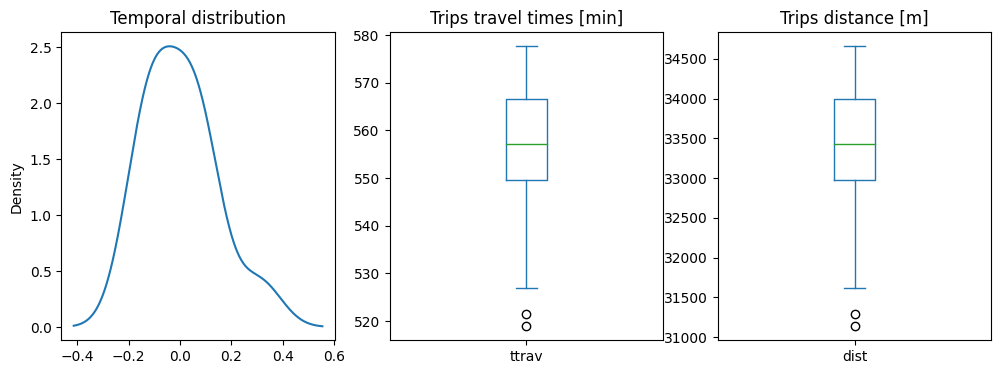

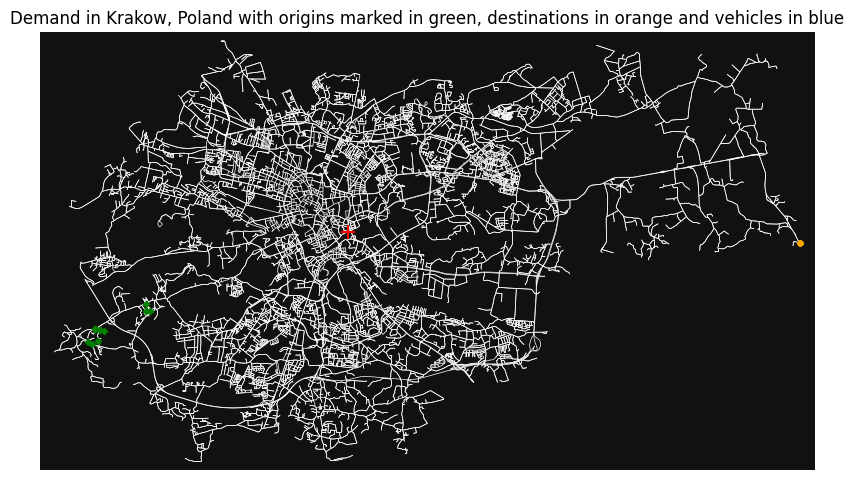

In [9]:
ExMAS.utils.plot_demand(inData, params)